In [3]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display
from matplotlib_inline import backend_inline
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np

In [4]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  # @save
    """绘制图像列表"""
    # figsize = (num_cols * scale, num_rows * scale)
    fig = plt.figure(figsize=(num_cols * scale, num_rows * scale))
    axes = fig.subplots(
        nrows=num_rows,
        ncols=num_cols,
        sharex=False,
        sharey=False,
        squeeze=True,
        subplot_kw=None,
        gridspec_kw=None,
    )
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.numpy(), cmap="gray")
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    plt.subplots_adjust(hspace=0.5, top=0.8)
    return axes


def get_mnist_labels(labels):  # @save
    """返回MNIST数据集的文本标签"""
    text_labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
    return [text_labels[int(i)] for i in labels]


class Animator:
    def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        axes.set_xlabel(xlabel)
        axes.set_ylabel(ylabel)
        axes.set_xscale(xscale)
        axes.set_yscale(yscale)
        axes.set_xlim(xlim)
        axes.set_ylim(ylim)
        if legend:
            axes.legend(legend)
        axes.grid()

    """For plotting data in animation."""

    def __init__(
        self,
        xlabel=None,
        ylabel=None,
        legend=None,
        xlim=None,
        ylim=None,
        xscale="linear",
        yscale="linear",
        fmts=("-", "m--", "g-.", "r:"),
        nrows=1,
        ncols=1,
        figsize=(4.9, 3.5),
    ):
        """Defined in :numref:`sec_softmax_scratch`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        backend_inline.set_matplotlib_formats("svg")
        self.fig = plt.figure(figsize=figsize)
        self.axes = self.fig.subplots(
            nrows=nrows,
            ncols=ncols,
            sharex=False,
            sharey=False,
            squeeze=True,
            subplot_kw=None,
            gridspec_kw=None,
        )
        if nrows * ncols == 1:
            self.axes = [
                self.axes,
            ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: Animator.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend
        )
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        self.axes[0].text(
            0.3,
            0.9,
            f"test acc {y[2]:.3f}",
            horizontalalignment="center",
            verticalalignment="center",
            transform=self.axes[0].transAxes,
        )
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


class TrainCallback(tf.keras.callbacks.Callback):  # @save
    """一个以可视化的训练进展的回调"""

    def __init__(self, net, train_iter, test_iter, num_epochs, device_name):
        self.animator = Animator(
            xlabel="epoch",
            xlim=[1, num_epochs],
            legend=["train loss", "train acc", "test acc"],
        )
        self.net = net
        self.train_iter = train_iter
        self.test_iter = test_iter
        self.num_epochs = num_epochs
        self.device_name = device_name

    def on_epoch_begin(self, epoch, logs=None):
        pass

    def on_epoch_end(self, epoch, logs):
        test_acc = self.net.evaluate(self.test_iter, verbose=0, return_dict=True)[
            "accuracy"
        ]
        metrics = (logs["loss"], logs["accuracy"], test_acc)
        self.animator.add(epoch + 1, metrics)
        if epoch == self.num_epochs - 1:
            print(
                f"loss {metrics[0]:.3f}, train acc {metrics[1]:.3f}, "
                f"test acc {metrics[2]:.3f}"
            )


Train set size 60000, test set size 10000
Data shape (28, 28)


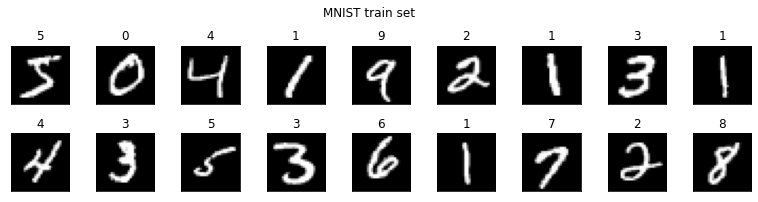

In [5]:
# Load dataset
mnist_train, mnist_test = tf.keras.datasets.mnist.load_data()

print("Train set size %d, test set size %d" % (len(mnist_train[0]), len(mnist_test[0])))
print("Data shape", mnist_train[0][0].shape)

X = tf.constant(mnist_train[0][:18])
y = tf.constant(mnist_train[1][:18])
show_images(X, 2, 9, get_mnist_labels(y))
plt.suptitle('MNIST train set');

In [6]:
# Same network structure as in the paper "基于FPGA的卷积神经网络手写数字识别系统的实现_王小雪"
def LeNet():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=3, kernel_size=5, activation='sigmoid'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=12, kernel_size=5,
                               activation='sigmoid'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10)])
tf.keras.backend.set_floatx('float16')

In [7]:
# prepare training data
batch_size = 256

process = lambda X, y: (tf.expand_dims(X, axis=3) / 255, tf.cast(y, dtype='int32'))
resize_fn = lambda X, y: (tf.image.resize_with_pad(X, None, None) if None else X, y)

train_iter = tf.data.Dataset.from_tensor_slices(process(*mnist_train)).batch(batch_size).shuffle(len(mnist_train[0])).map(resize_fn)
test_iter = tf.data.Dataset.from_tensor_slices(process(*mnist_test)).batch(batch_size).map(resize_fn)

loss 0.061, train acc 0.994, test acc 0.983


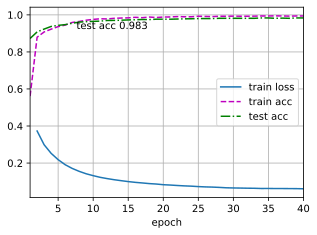

In [8]:
# model fitting
if len(tf.config.experimental.list_physical_devices('GPU')) >= 1:
    device = tf.device(f'/GPU:{0}')
else:
    device = tf.device('/CPU:0')
device_name = device._device_name
strategy = tf.distribute.OneDeviceStrategy(device_name)

lr = 0.9
num_epochs = 40
with strategy.scope():
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    net = LeNet()
    net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
train_callback = TrainCallback(net, train_iter, test_iter, num_epochs, device_name)
earlystop_callback = EarlyStopping(monitor='accuracy', min_delta=0.0001, patience=5)
reduce_lr_callback = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=3)
checkpoint_callback = ModelCheckpoint('./weights/best_model.h5', monitor='accuracy', save_best_only=True)
net.fit(train_iter, epochs=num_epochs, verbose=0, callbacks=[train_callback, earlystop_callback, reduce_lr_callback, checkpoint_callback])

In [9]:
# model structure
X = np.random.uniform(size=(1, 28, 28, 1))
for layer in net.layers:
    X = layer(X)
    print(layer.__class__.__name__, X.shape)
    for item in layer.weights:
        print('  ', item.name, '  \tshape: ', item.shape)

Conv2D (1, 24, 24, 3)
   conv2d/kernel:0   	shape:  (5, 5, 1, 3)
   conv2d/bias:0   	shape:  (3,)
AveragePooling2D (1, 12, 12, 3)
Conv2D (1, 8, 8, 12)
   conv2d_1/kernel:0   	shape:  (5, 5, 3, 12)
   conv2d_1/bias:0   	shape:  (12,)
AveragePooling2D (1, 4, 4, 12)
Flatten (1, 192)
Dense (1, 10)
   dense/kernel:0   	shape:  (192, 10)
   dense/bias:0   	shape:  (10,)


In [13]:
# path to your Vitis HLS testbehch folder
path = 'D:/Project/FPGA/HLS/LeNet/test/'

In [24]:
# generate weight and bias files
file = open(path+'LeNet_weights.txt', 'w')
bias_arr = net.layers[0].get_weights()[1]
arr = net.layers[0].get_weights()[0].reshape(-1)
for i in range(25*3):
    file.write('%.4f ' % arr[i])
file.write('\n')
for i in range(3):
    file.write('%.4f ' % bias_arr[i])
file.write('\n')

bias_arr = net.layers[2].get_weights()[1]
arr = net.layers[2].get_weights()[0].reshape(-1)
for i in range(25*12*3):
    file.write('%.4f ' % arr[i])
file.write('\n')
for i in range(12):
    file.write('%.4f ' % bias_arr[i])
file.write('\n')

arr = net.layers[5].get_weights()[0].reshape(-1)
for i in range(1920):
    file.write('%.4f ' % arr[i])
file.write('\n')
arr = net.layers[5].get_weights()[1].reshape(-1)
for i in range(10):
    file.write('%.4f ' % arr[i])
file.close()

In [31]:
# generate MNIST test data [100]
file = open(path+'mnist_test_0_100.txt', 'w')
for i in range(100):
    arr = mnist_test[0][i].reshape(-1)
    for j in range(28*28):
        file.write(str(arr[j]) + ' ')
    file.write('\n')
    file.write(str(mnist_test[1][i]) + '\n')
file.close()

In [57]:
# generate MNIST test data [1000]
file = open(path+'mnist_test_0_1000.txt', 'w')
for i in range(1000):
    arr = mnist_test[0][i].reshape(-1)
    for j in range(28*28):
        file.write(str(arr[j]) + ' ')
    file.write('\n')
    file.write(str(mnist_test[1][i]) + '\n')
file.close()

In [15]:
# generate conv2d_layer1 output
file = open(path+'conv2d_layer1_output.txt', 'w')
for i in range(100):
    output = net.layers[0](mnist_test[0][i].reshape(1, 28, 28, 1)/255.).numpy()
    for j in range(3):
        arr = output[0,:,:,j].reshape(-1)
        for z in range(24*24):
            file.write(str(round(arr[z], 4)) + ' ')
        file.write('\n')
file.close()

In [26]:
# generate avgpool_layer2 output
file = open(path+'avgpool_layer2_output.txt', 'w')
for i in range(100):
    layer1_output = net.layers[0](mnist_test[0][i].reshape(1, 28, 28, 1)/255.).numpy()
    output = net.layers[1](layer1_output).numpy()
    for j in range(3):
        arr = output[0,:,:,j].reshape(-1)
        for z in range(12*12):
            file.write(str(round(arr[z], 4)) + ' ')
        file.write('\n')
file.close()

In [27]:
# generate conv2d_layer3 output
file = open(path+'conv2d_layer3_output.txt', 'w')
for i in range(100):
    layer1_output = net.layers[0](mnist_test[0][i].reshape(1, 28, 28, 1)/255.).numpy()
    layer2_output = net.layers[1](layer1_output).numpy()
    output = net.layers[2](layer2_output).numpy()
    for j in range(12):
        arr = output[0,:,:,j].reshape(-1)
        for z in range(8*8):
            file.write(str(round(arr[z], 4)) + ' ')
        file.write('\n')
file.close()

In [28]:
# generate avgpool_layer4 output
file = open(path+'avgpool_layer4_output.txt', 'w')
for i in range(100):
    layer1_output = net.layers[0](mnist_test[0][i].reshape(1, 28, 28, 1)/255.).numpy()
    layer2_output = net.layers[1](layer1_output).numpy()
    layer3_output = net.layers[2](layer2_output).numpy()
    output = net.layers[3](layer3_output).numpy()
    for j in range(12):
        arr = output[0,:,:,j].reshape(-1)
        for z in range(4*4):
            file.write(str(round(arr[z], 4)) + ' ')
        file.write('\n')
file.close()

In [29]:
# generate dense_layer5 output
file = open(path+'dense_layer5_output.txt', 'w')
for i in range(100):
    layer1_output = net.layers[0](mnist_test[0][i].reshape(1, 28, 28, 1)/255.).numpy()
    layer2_output = net.layers[1](layer1_output).numpy()
    layer3_output = net.layers[2](layer2_output).numpy()
    layer4_output = net.layers[3](layer3_output).numpy()
    layer5_output = net.layers[4](layer4_output).numpy()
    output = net.layers[5](layer5_output).numpy()
    for j in range(10):
        file.write('%.4f ' % output[0,j])
    file.write('\n')
file.close()